In [180]:
%matplotlib inline
from IPython.display import HTML, display
import datasets
from datasets import load_metric
import pathlib
from collections import defaultdict
from gensim.parsing.preprocessing import STOPWORDS
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import pytextrank
import spacy

In [4]:
RAW_SUMMARIZATION_DATASETS_DIR = "../datasets/raw/supervised/summarization"

In [2]:
##https://medium.com/swlh/text-summarization-guide-exploratory-data-analysis-on-text-data-4e22ce2dd6ad

def count_sentences(examples):
    return {
        "document_sentence_count": [len(document) for document in examples["document"]],
        "summary_sentence_count": [len(document) for document in examples["summary"]],
    }

def count_words(examples):
    return {
        "document_word_count": [sum(len(item.split()) for item in document) for document in examples["document"]],
        "summary_word_count": [sum(len(item.split()) for item in document) for document in examples["summary"]],
    }

def count_chars(examples):
    return {
        "document_char_count": [sum(len("".join(item.split())) for item in document) for document in examples["document"]],
        "summary_char_count": [sum(len("".join(item.split())) for item in document) for document in examples["summary"]],
    }

def sentence_density(examples):
    return {
        "document_sentence_density": [document[0]/(document[1] if document[1] else 1) for document in zip(examples["document_sentence_count"], examples["document_word_count"])], 
        "summary_sentence_density": [document[0]/(document[1] if document[1] else 1)  for document in zip(examples["summary_sentence_count"], examples["summary_word_count"])],
    }



def _count_stopwords(text, stopwords=STOPWORDS):
    ''' Return the number of stopwords in the text
        Input:
            - text: string
            - stopwords: list of string, containing the stopwords
        Output:
            - int, number of stopwords in the text argument
    '''
    stopwords_x = [w for w in "\n".join(text).split() if w.lower() in stopwords]
    
    return len(stopwords_x)

def count_stopwords(examples):
    return {
        "document_stopword_count": [_count_stopwords(document) for document in examples["document"]],
        "summary_stopword_count": [_count_stopwords(document) for document in examples["summary"]]
    }


def load_dataset_stats(dataset):

    features = datasets.features.Features({
    'document': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None),
    'summary': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None)
    })
    dataset_name, splits = dataset

    dataset = datasets.load_dataset("json", dataset_name, data_files=splits, features=features,)
    removed_cols = list(set(column_name for sublist in dataset.values() for column_name in sublist.column_names))

    datasets_info = (
        dataset
        .map(count_sentences,batched=True)
        .map(count_words,batched=True,)
        .map(count_chars, batched=True)
        .map(sentence_density,batched=True)
        .map(count_stopwords, batched=True, remove_columns=removed_cols)
        )
    
    return datasets_info


def load_data_splits_from_dir(directory, ext="json.gz"):
    splits = defaultdict(dict)
    directory_files = pathlib.Path(directory).glob(f"**/*.{ext}")
    for file_path in directory_files:
        data_split = file_path.stem.split(".")[0]
        splits[file_path.parent.stem][data_split] = str(file_path.resolve())
    return dict(splits)


In [ ]:

data_splits = load_data_splits_from_dir(RAW_SUMMARIZATION_DATASETS_DIR)
for dataset in tqdm(data_splits.items()):
    ## TODO Write Dataset loading script
    # https://huggingface.co/docs/datasets/v1.12.0/dataset_script.html
    dataset_info = load_dataset_stats(dataset)
    dataset_name, _ = dataset
    for split_name,split_info in dataset_info.items():
        outfile = pathlib.Path(RAW_SUMMARIZATION_DATASETS_DIR).joinpath(dataset_name, f"{split_name}_info.csv").resolve()
        split_df = split_info.to_pandas()
        split_df.to_csv(outfile, index=False, index_label=False)


In [208]:
def make_kdeplot(dataset, x_col, hue_col, ax):
    sns.kdeplot(
        data=dataset, x=x_col, hue=hue_col,
        fill=True, common_norm=False, palette="crest", ax=ax,
        alpha=.5, linewidth=0)

def make_boxplot(dataset, x_col, y_col, ax):
    sns.boxplot(
        data=dataset, y=y_col, x=x_col, palette="crest",
        dodge=False, orient="v", ax=ax)


    

def show_data_dists(dataset, name):
    _, ax = plt.subplots(nrows=4, ncols=4, figsize=(25, 15))
    make_kdeplot(dataset, x_col="document_sentence_count", hue_col="split",ax=ax[0][0])
    make_kdeplot(dataset, x_col="document_word_count", hue_col="split",ax=ax[0][1])
    make_kdeplot(dataset, x_col="document_char_count", hue_col="split",ax=ax[0][2])
    make_kdeplot(dataset, x_col="document_stopword_count", hue_col="split",ax=ax[0][3])

    
    make_boxplot(dataset, x_col="split", y_col="document_sentence_count", ax=ax[1][0])
    make_boxplot(dataset, x_col="split", y_col="document_word_count", ax=ax[1][1])
    make_boxplot(dataset, x_col="split", y_col="document_char_count", ax=ax[1][2])
    make_boxplot(dataset, x_col="split", y_col="document_stopword_count", ax=ax[1][3])


    make_kdeplot(dataset, x_col="summary_sentence_count", hue_col="split",ax=ax[2][0])
    make_kdeplot(dataset, x_col="summary_word_count", hue_col="split",ax=ax[2][1])
    make_kdeplot(dataset, x_col="summary_char_count", hue_col="split",ax=ax[2][2])
    make_kdeplot(dataset, x_col="summary_stopword_count", hue_col="split",ax=ax[2][3])

    
    make_boxplot(dataset, x_col="split", y_col="summary_sentence_count", ax=ax[3][0])
    make_boxplot(dataset, x_col="split", y_col="summary_word_count", ax=ax[3][1])
    make_boxplot(dataset, x_col="split", y_col="summary_char_count", ax=ax[3][2])
    make_boxplot(dataset, x_col="split", y_col="summary_stopword_count", ax=ax[3][3])

    plt.suptitle(f"Descriptive Statistics for {name} Dataset", fontsize=20)
    plt.tight_layout()
    plt.show()

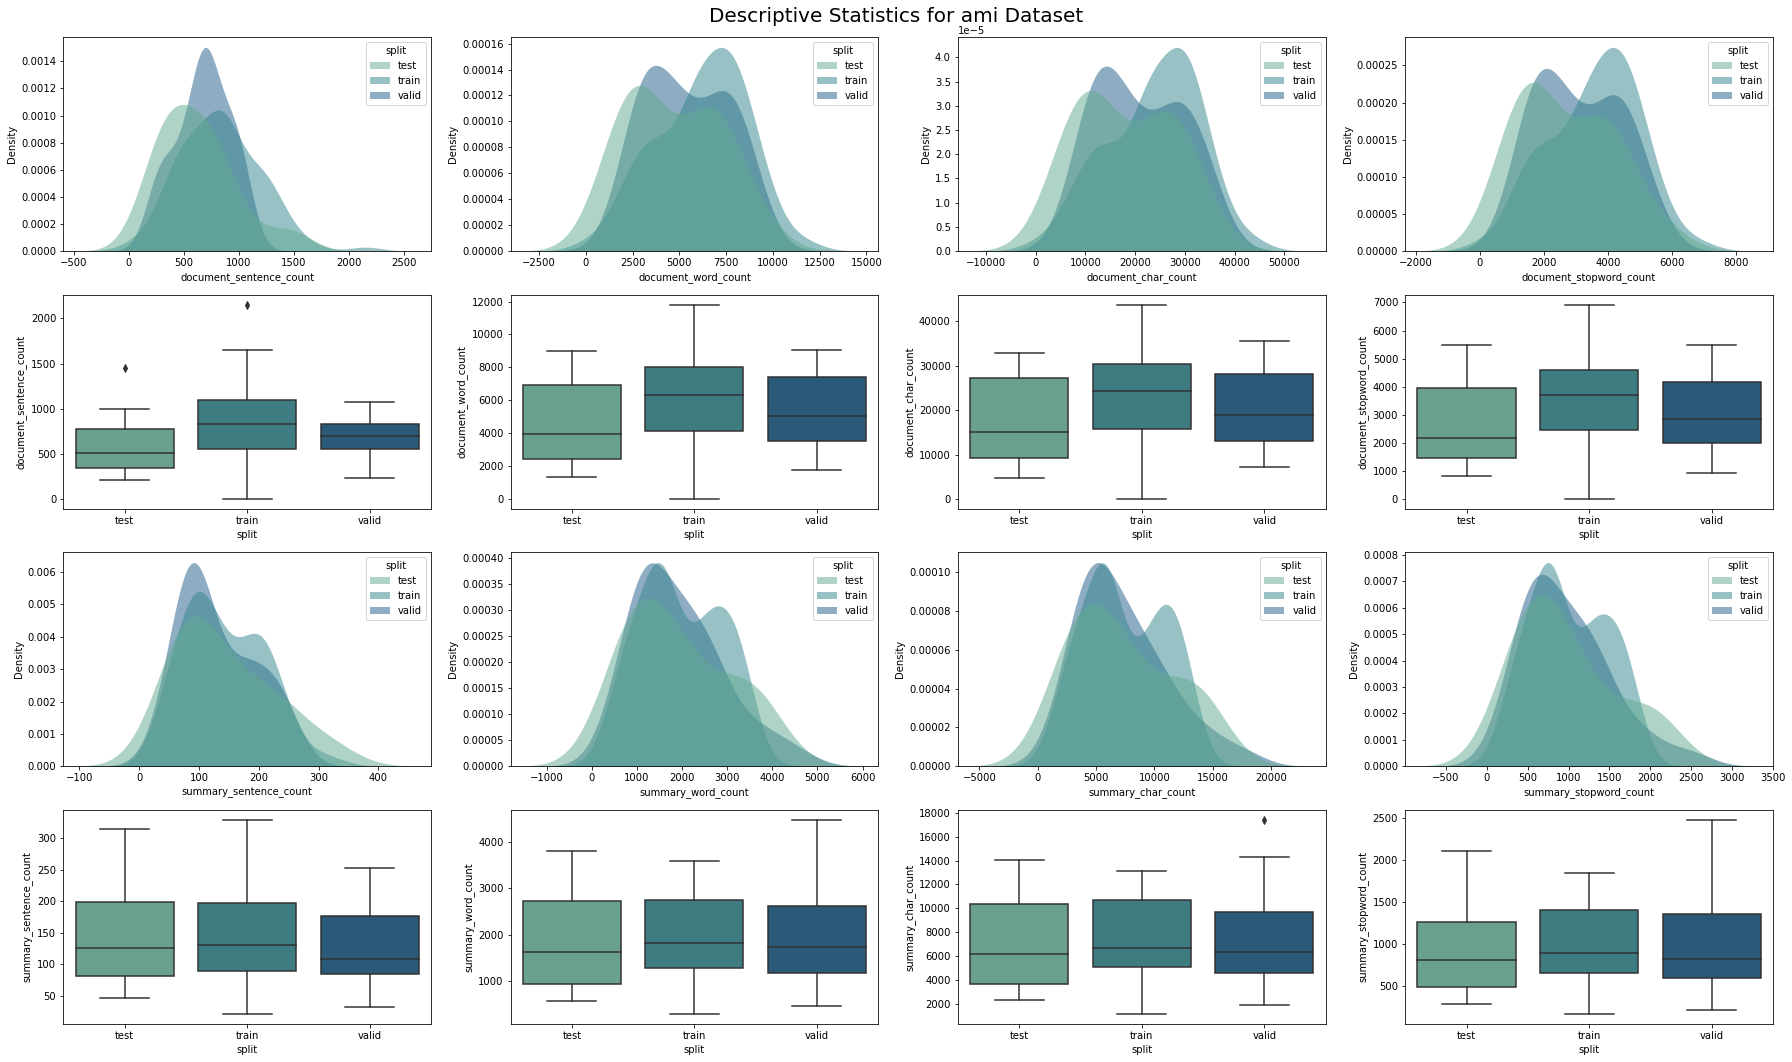

count     mean     std     min      25%  \
ami test  document char_count        13.00 18087.08 9478.36 4770.00  9311.00   
                   sentence_count    13.00   619.23  343.82  215.00   345.00   
                   sentence_density  13.00     0.13    0.02    0.11     0.13   
                   stopword_count    13.00  2702.31 1466.85  827.00  1468.00   
                   word_count        13.00  4698.77 2481.55 1326.00  2445.00   
          summary  char_count        13.00  7275.15 4277.15 2269.00  3670.00   
                   sentence_count    13.00   142.31   81.20   47.00    82.00   
                   sentence_density  13.00     0.08    0.01    0.06     0.07   
                   stopword_count    13.00   979.15  603.34  289.00   485.00   
                   word_count        13.00  1908.54 1116.73  578.00   950.00   
    train document char_count        95.00 23670.63 9216.79    0.00 15814.00   
                   sentence_count    95.00   830.88  366.41    0.00   554.50   
                   sentence_density  95.00     0.13    0.03    0.00     0.12   
                   stopword_count    95.00  3557.26 1403.14    0.00  2461.50   
                   word_count        95.00  6177.65 2420.14    0.00  4152.50   
          summary  char_count        95.00  7443.33 3404.71 1113.00  5028.00   
                   sentence_count    95.00   142.48   67.08   21.00    89.00   
                   sentence_density  95.00     0.07    0.01    0.05     0.06   
                   stopword_count    95.00  1007.49  464.00  165.00   655.00   
                   word_count        95.00  1964.75  890.51  299.00  1279.50   
    valid document char_count        29.00 20877.34 8637.88 7108.00 13066.00   
                   sentence_count    29.00   674.86  241.03  234.00   558.00   
                   sentence_density  29.00     0.13    0.02    0.09     0.12   
                   stopword_count    29.00  3087.34 1311.04  922.00  1979.00   
                   word_count        29.00  5397.00 2202.61 1776.00  3529.00   
          summary  char_count        29.00  7264.62 3791.94 1895.00  4547.00   
                   sentence_count    29.00   130.97   62.84   33.00    84.00   
                   sentence_density  29.00     0.07    0.01    0.05     0.06   
                   stopword_count    29.00   972.52  536.52  208.00   594.00   
                   word_count        29.00  1904.69  982.88  469.00  1181.00   

                                         50%      75%      max  
ami test  document char_count       15164.00 27179.00 32859.00  
                   sentence_count     506.00   774.00  1450.00  
                   sentence_density     0.14     0.14     0.16  
                   stopword_count    2157.00  3942.00  5496.00  
                   word_count        3952.00  6903.00  9014.00  
          summary  char_count        6161.00 10341.00 14079.00  
                   sentence_count     126.00   199.00   314.00  
                   sentence_density     0.08     0.08     0.10  
                   stopword_count     809.00  1265.00  2105.00  
                   word_count        1626.00  2729.00  3803.00  
    train document char_count       24253.00 30462.50 43824.00  
                   sentence_count     825.00  1092.50  2154.00  
                   sentence_density     0.13     0.15     0.20  
                   stopword_count    3689.00  4590.00  6928.00  
                   word_count        6301.00  8010.50 11822.00  
          summary  char_count        6702.00 10689.50 13157.00  
                   sentence_count     131.00   197.50   329.00  
                   sentence_density     0.07     0.08     0.11  
                   stopword_count     893.00  1407.50  1842.00  
                   word_count        1820.00  2742.00  3581.00  
    valid document char_count       19001.00 28225.00 35602.00  
                   sentence_count     699.00   826.00  1076.00  
                   sentence_density     0.12     0.14     0.1

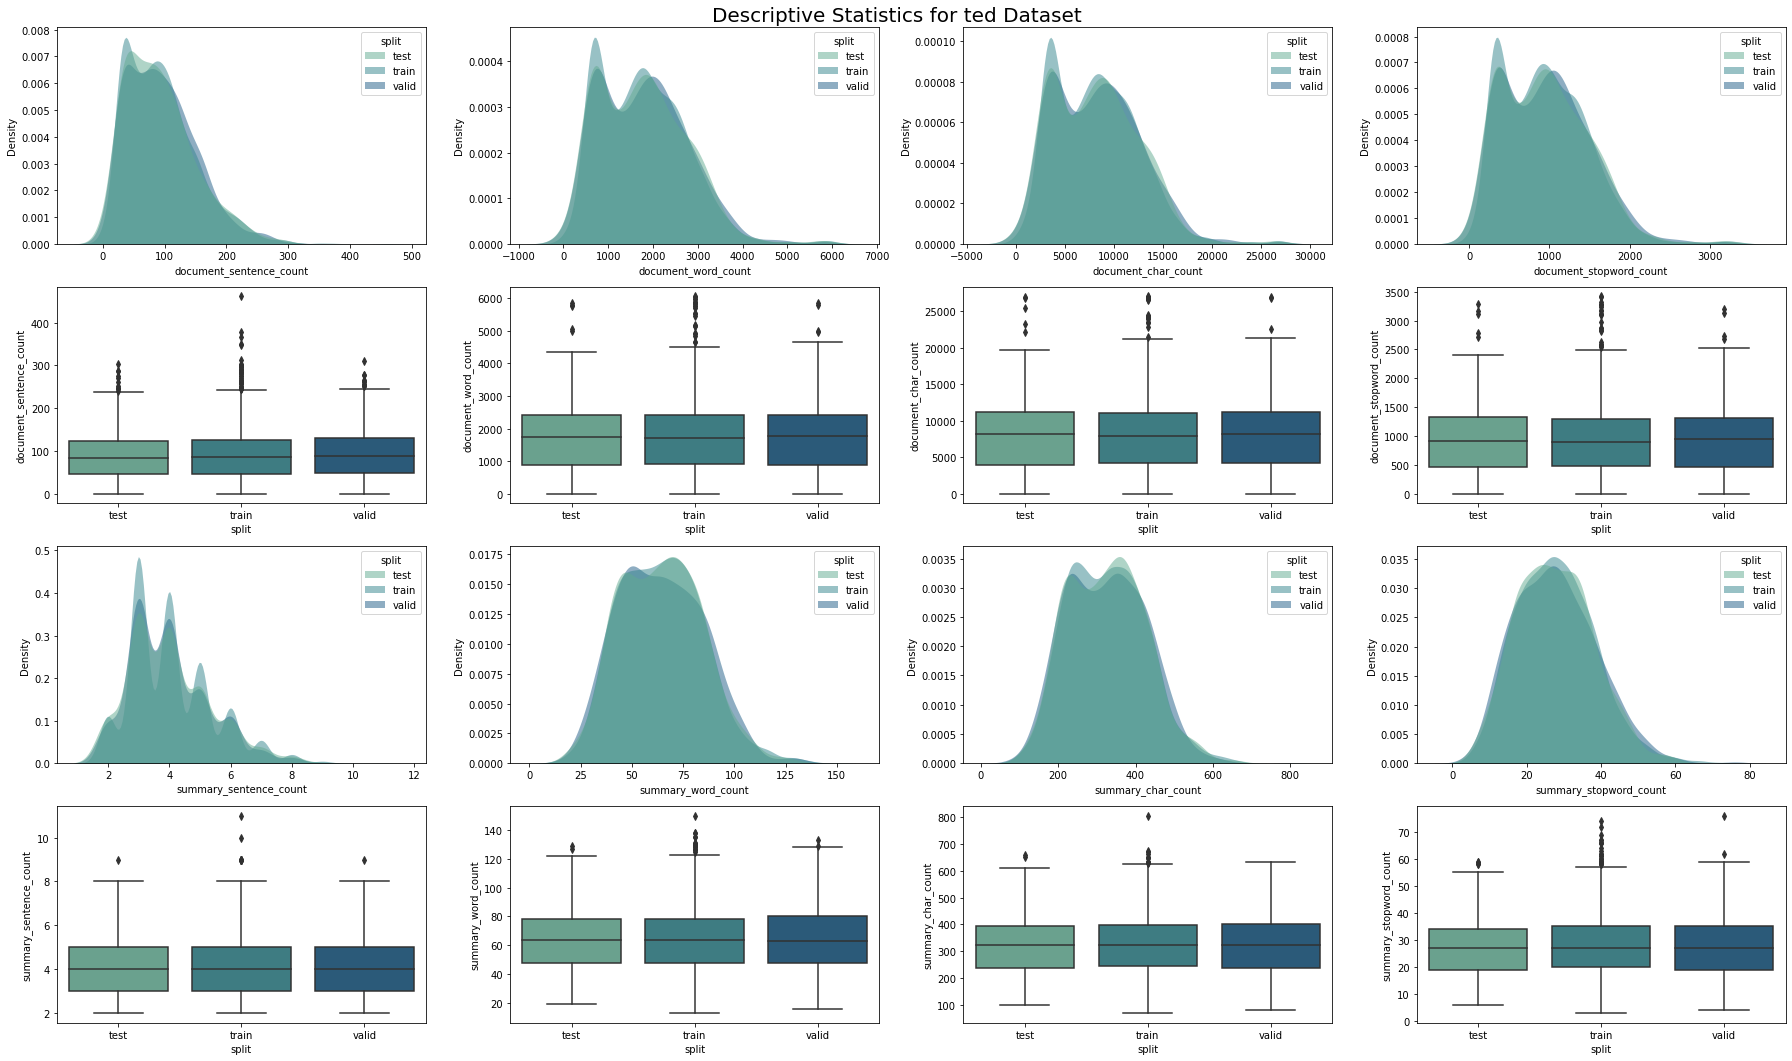

count    mean     std    min     25%  \
ted test  document char_count        606.00 8136.31 4388.51   0.00 3980.75   
                   sentence_count    606.00   92.16   56.46   0.00   47.00   
                   sentence_density  606.00    0.05    0.02   0.00    0.04   
                   stopword_count    606.00  938.66  540.28   0.00  454.00   
                   word_count        606.00 1759.96  975.42   0.00  869.00   
          summary  char_count        606.00  324.36   99.27 101.00  239.00   
                   sentence_count    606.00    4.00    1.34   2.00    3.00   
                   sentence_density  606.00    0.06    0.02   0.03    0.05   
                   stopword_count    606.00   27.53   10.24   6.00   19.00   
                   word_count        606.00   64.11   19.91  19.00   48.00   
    train document char_count       2828.00 8118.03 4260.27   0.00 4227.75   
                   sentence_count   2828.00   93.89   56.87   0.00   47.00   
                   sentence_density 2828.00    0.05    0.01   0.00    0.04   
                   stopword_count   2828.00  937.08  523.82   0.00  476.75   
                   word_count       2828.00 1759.56  949.32   0.00  915.75   
          summary  char_count       2828.00  324.96  100.89  71.00  244.00   
                   sentence_count   2828.00    4.04    1.35   2.00    3.00   
                   sentence_density 2828.00    0.07    0.02   0.03    0.05   
                   stopword_count   2828.00   27.83   10.56   3.00   20.00   
                   word_count       2828.00   64.32   20.34  13.00   48.00   
    valid document char_count        606.00 8218.17 4391.33   0.00 4160.50   
                   sentence_count    606.00   94.48   55.52   0.00   48.00   
                   sentence_density  606.00    0.05    0.02   0.00    0.04   
                   stopword_count    606.00  951.06  540.59   0.00  457.50   
                   word_count        606.00 1782.85  976.19   0.00  878.75   
          summary  char_count        606.00  323.65  100.86  82.00  238.00   
                   sentence_count    606.00    3.97    1.29   2.00    3.00   
                   sentence_density  606.00    0.06    0.02   0.02    0.05   
                   stopword_count    606.00   27.76   10.94   4.00   19.00   
                   word_count        606.00   64.14   20.68  16.00   48.00   

                                        50%      75%      max  
ted test  document char_count       8122.00 11163.00 26916.00  
                   sentence_count     83.00   123.00   304.00  
                   sentence_density    0.05     0.06     0.23  
                   stopword_count    909.00  1323.25  3288.00  
                   word_count       1736.00  2411.75  5852.00  
          summary  char_count        324.00   394.75   659.00  
                   sentence_count      4.00     5.00     9.00  
                   sentence_density    0.06     0.07     0.12  
                   stopword_count     27.00    34.00    59.00  
                   word_count         64.00    78.00   129.00  
    train document char_count       7927.50 11053.50 27054.00  
                   sentence_count     86.00   126.00   461.00  
                   sentence_density    0.05     0.06     0.15  
                   stopword_count    902.00  1296.00  3418.00  
                   word_count       1706.00  2404.00  6060.00  
          summary  char_count        322.00   396.00   804.00  
                   sentence_count      4.00     5.00    11.00  
                   sentence_density    0.06     0.08     0.21  
                   stopword_count     27.00    35.00    74.00  
                   word_count         64.00    78.00   150.00  
    valid document char_count       8127.50 11202.00 26938.00  
                   sentence_count     88.00   129.00   311.00  
                   sentence_density    0.05     0.06     0.36  
                   stopword_count    944.50  1310.00  3192.00  
                   

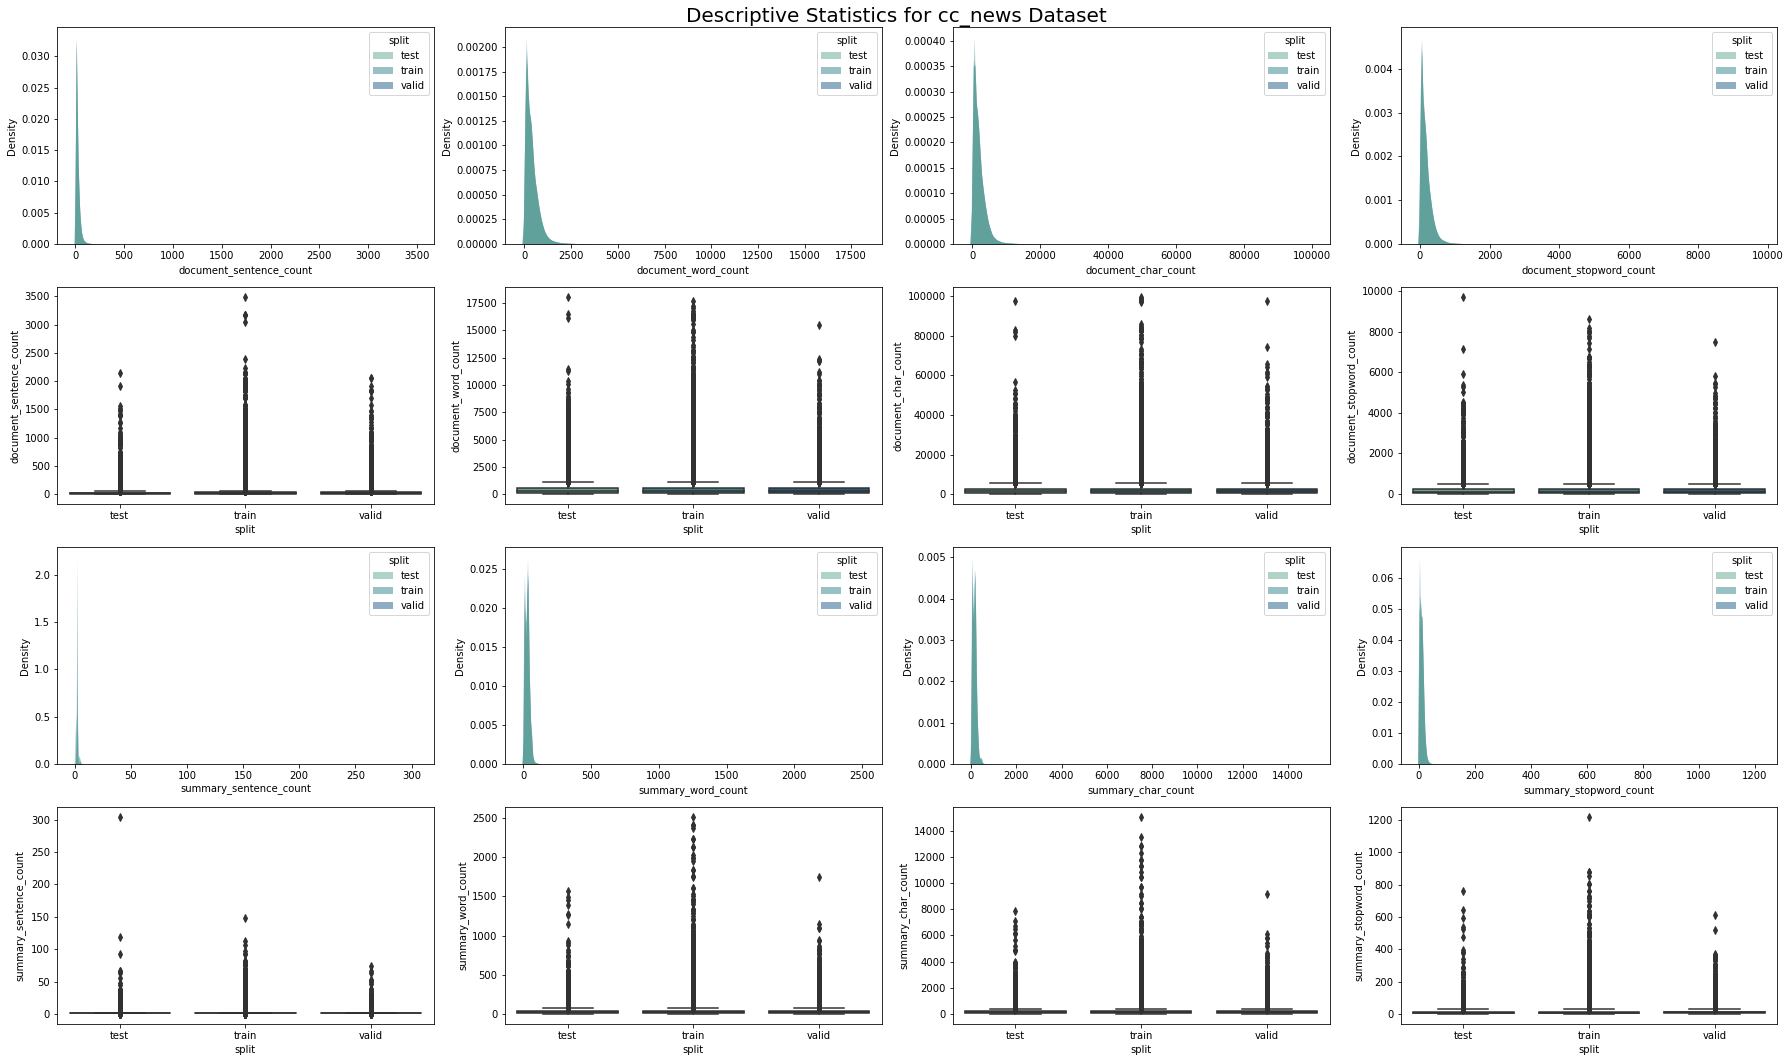

count    mean     std   min  \
cc_news test  document char_count        70825.00 1981.71 2332.45 53.00   
                       sentence_count    70825.00   22.37   38.96  1.00   
                       sentence_density  70825.00    0.06    0.03  0.00   
                       stopword_count    70825.00  169.95  205.72  0.00   
                       word_count        70825.00  395.06  462.74 15.00   
              summary  char_count        70825.00  152.52  150.46  0.00   
                       sentence_count    70825.00    2.08    1.77  0.00   
                       sentence_density  70825.00    0.09    0.06  0.00   
                       stopword_count    70825.00    9.62   11.41  0.00   
                       word_count        70825.00   29.14   28.75  0.00   
        train document char_count       566592.00 1991.58 2364.92 42.00   
                       sentence_count   566592.00   22.48   41.11  1.00   
                       sentence_density 566592.00    0.06    0.03  0.00   
                       stopword_count   566592.00  170.73  207.51  0.00   
                       word_count       566592.00  396.85  468.80 15.00   
              summary  char_count       566592.00  151.82  152.54  0.00   
                       sentence_count   566592.00    2.07    1.31  0.00   
                       sentence_density 566592.00    0.09    0.06  0.00   
                       stopword_count   566592.00    9.58   11.50  0.00   
                       word_count       566592.00   29.00   28.74  0.00   
        valid document char_count        70824.00 2002.13 2396.05 49.00   
                       sentence_count    70824.00   22.78   43.78  1.00   
                       sentence_density  70824.00    0.06    0.03  0.00   
                       stopword_count    70824.00  171.32  207.42  0.00   
                       word_count        70824.00  398.76  472.40 15.00   
              summary  char_count        70824.00  152.43  144.76  0.00   
                       sentence_count    70824.00    2.08    1.26  0.00   
                       sentence_density  70824.00    0.09    0.06  0.00   
                       stopword_count    70824.00    9.64   10.75  0.00   
                       word_count        70824.00   29.13   27.35  0.00   

                                           25%     50%     75%      max  
cc_news test  document char_count       632.00 1447.00 2629.00 97397.00  
                       sentence_count     7.00   15.00   27.00  2136.00  
                       sentence_density   0.04    0.05    0.07     0.60  
                       stopword_count    50.00  121.00  226.00  9719.00  
                       word_count       125.00  290.00  524.00 18062.00  
              summary  char_count        76.00  146.00  194.00  7875.00  
                       sentence_count     2.00    2.00    2.00   304.00  
                       sentence_density   0.06    0.08    0.11     1.00  
                       stopword_count     3.00    8.00   14.00   762.00  
                       word_count        14.00   28.00   38.00  1566.00  
        train document char_count       630.00 1454.00 2645.00 99629.00  
                       sentence_count     7.00   15.00   28.00  3489.00  
                       sentence_density   0.04    0.05    0.07     0.84  
                       stopword_count    50.00  122.00  228.00  8623.00  
                       word_count       125.00  291.00  527.00 17741.00  
              summary  char_count        74.00  146.00  195.00 15046.00  
                       sentence_count     2.00    2.00    2.00   148.00  
                       sentence_density   0.06    0.08    0.11     1.00  
                       stopword_count     3.00    8.00   14.00  1218.00  
                       word_count        14.00   28.00   38.00  2512.00  
        valid document char_count       629.00 1450.00 2644.00 97424.00  
                       sentence_count     7.00   15.00   28.00  2060.00  
                

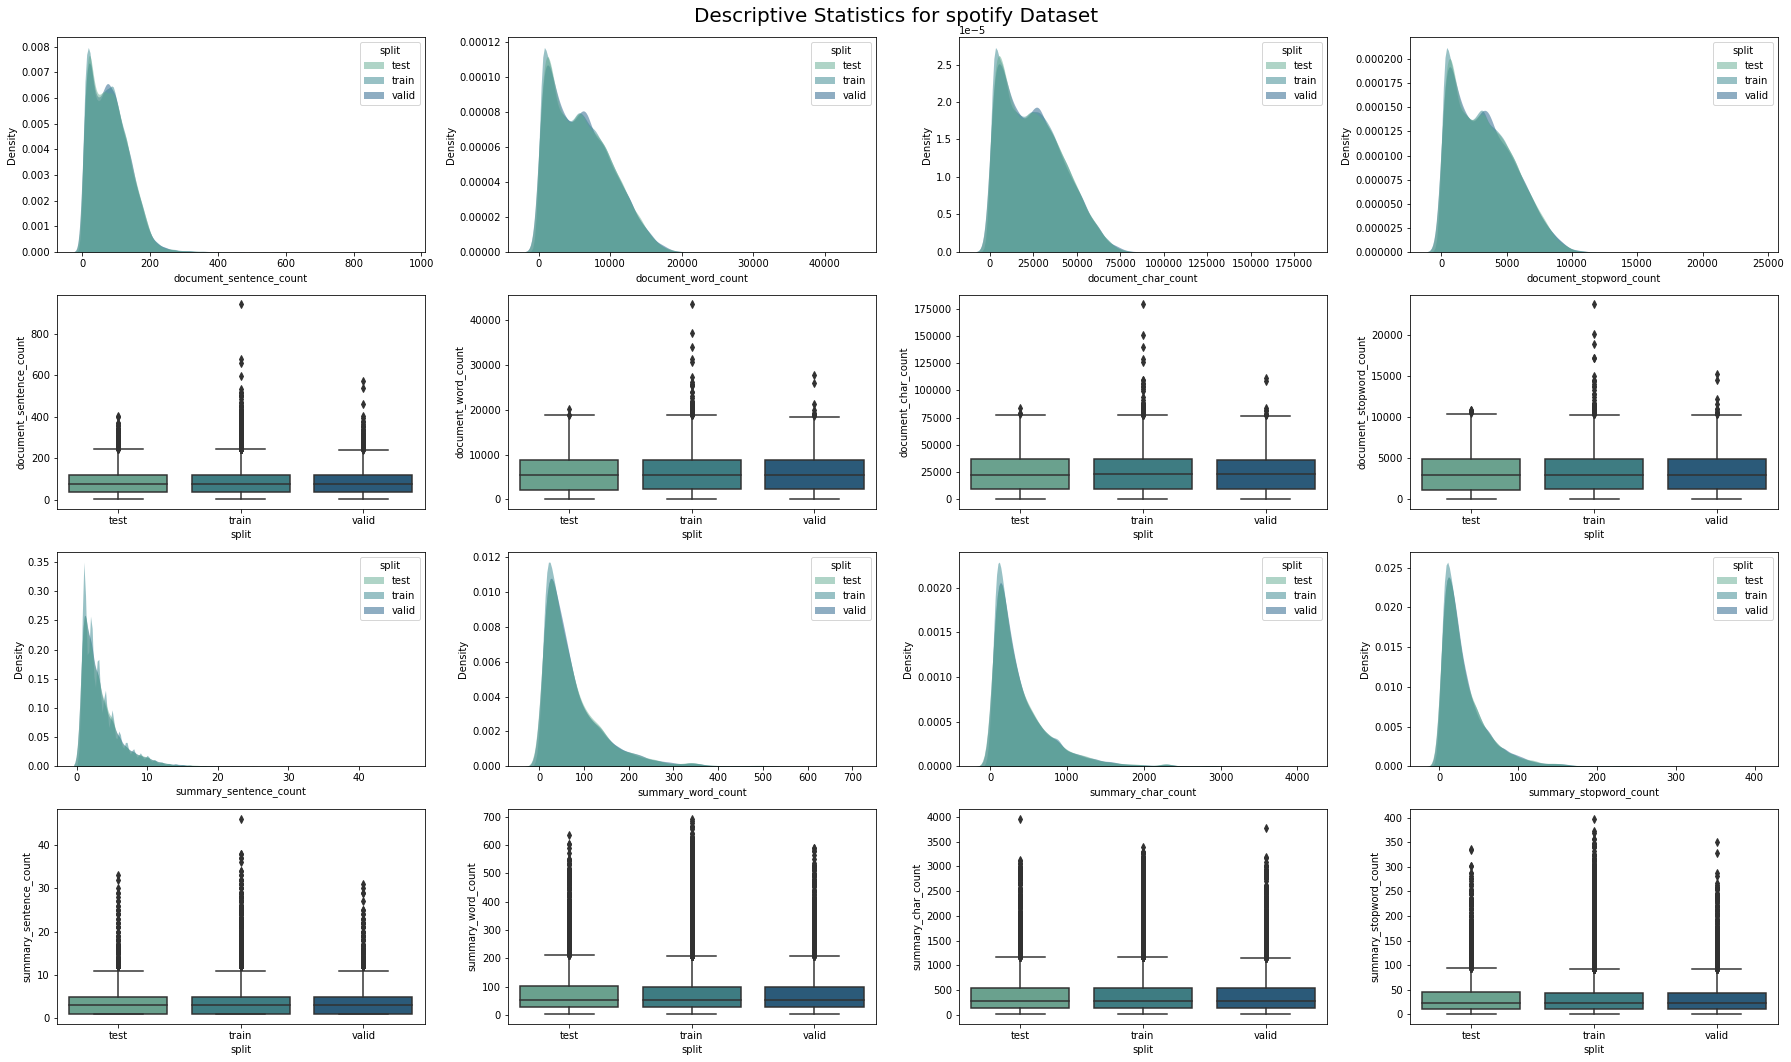

count     mean      std   min  \
spotify test  document char_count        9940.00 24565.97 17070.60 44.00   
                       sentence_count    9940.00    81.30    54.61  1.00   
                       sentence_density  9940.00     0.02     0.01  0.01   
                       stopword_count    9940.00  3240.10  2286.44  6.00   
                       word_count        9940.00  5863.79  4131.73 12.00   
              summary  char_count        9940.00   414.50   425.82 14.00   
                       sentence_count    9940.00     3.51     3.08  1.00   
                       sentence_density  9940.00     0.05     0.03  0.01   
                       stopword_count    9940.00    32.90    33.15  0.00   
                       word_count        9940.00    76.76    74.54  3.00   
        train document char_count       79173.00 24687.60 17132.94 55.00   
                       sentence_count   79173.00    81.67    55.41  1.00   
                       sentence_density 79173.00     0.02     0.01  0.01   
                       stopword_count   79173.00  3255.05  2297.73  3.00   
                       word_count       79173.00  5891.62  4148.81 12.00   
              summary  char_count       79173.00   409.57   415.77 11.00   
                       sentence_count   79173.00     3.50     3.07  1.00   
                       sentence_density 79173.00     0.05     0.03  0.00   
                       stopword_count   79173.00    32.76    33.02  0.00   
                       word_count       79173.00    76.06    73.56  3.00   
        valid document char_count        9952.00 24636.78 17129.77 65.00   
                       sentence_count    9952.00    81.56    55.16  1.00   
                       sentence_density  9952.00     0.02     0.01  0.01   
                       stopword_count    9952.00  3251.88  2297.59  1.00   
                       word_count        9952.00  5880.12  4145.02 14.00   
              summary  char_count        9952.00   409.38   414.50 17.00   
                       sentence_count    9952.00     3.50     3.05  1.00   
                       sentence_density  9952.00     0.05     0.02  0.00   
                       stopword_count    9952.00    32.60    32.18  0.00   
                       word_count        9952.00    75.85    72.51  3.00   

                                            25%      50%      75%       max  
spotify test  document char_count       9376.75 22713.50 36814.50  83724.00  
                       sentence_count     35.00    75.00   118.00    402.00  
                       sentence_density    0.01     0.01     0.02      0.47  
                       stopword_count   1199.75  2969.50  4887.00  10909.00  
                       word_count       2176.75  5402.00  8834.50  20175.00  
              summary  char_count        132.00   272.00   545.00   3963.00  
                       sentence_count      1.00     3.00     5.00     33.00  
                       sentence_density    0.04     0.05     0.06      0.33  
                       stopword_count     11.00    22.00    44.00    336.00  
                       word_count         27.00    53.00   101.00    636.00  
        train document char_count       9578.00 22893.00 36801.00 178902.00  
                       sentence_count     35.00    76.00   118.00    943.00  
                       sentence_density    0.01     0.01     0.02      0.54  
                       stopword_count   1231.00  2991.00  4882.00  23764.00  
                       word_count       2227.00  5421.00  8841.00  43504.00  
              summary  char_count        132.00   271.00   543.00   3391.00  
                       sentence_count      1.00     3.00     5.00     46.00  
                       sentence_density    0.04     0.05     0.06      0.33  
                       stopword_count     11.00    22.00    43.00    398.00  
                       word_count         27.00    53.00    99.00    692.00  
        valid document char_count       9647.00 

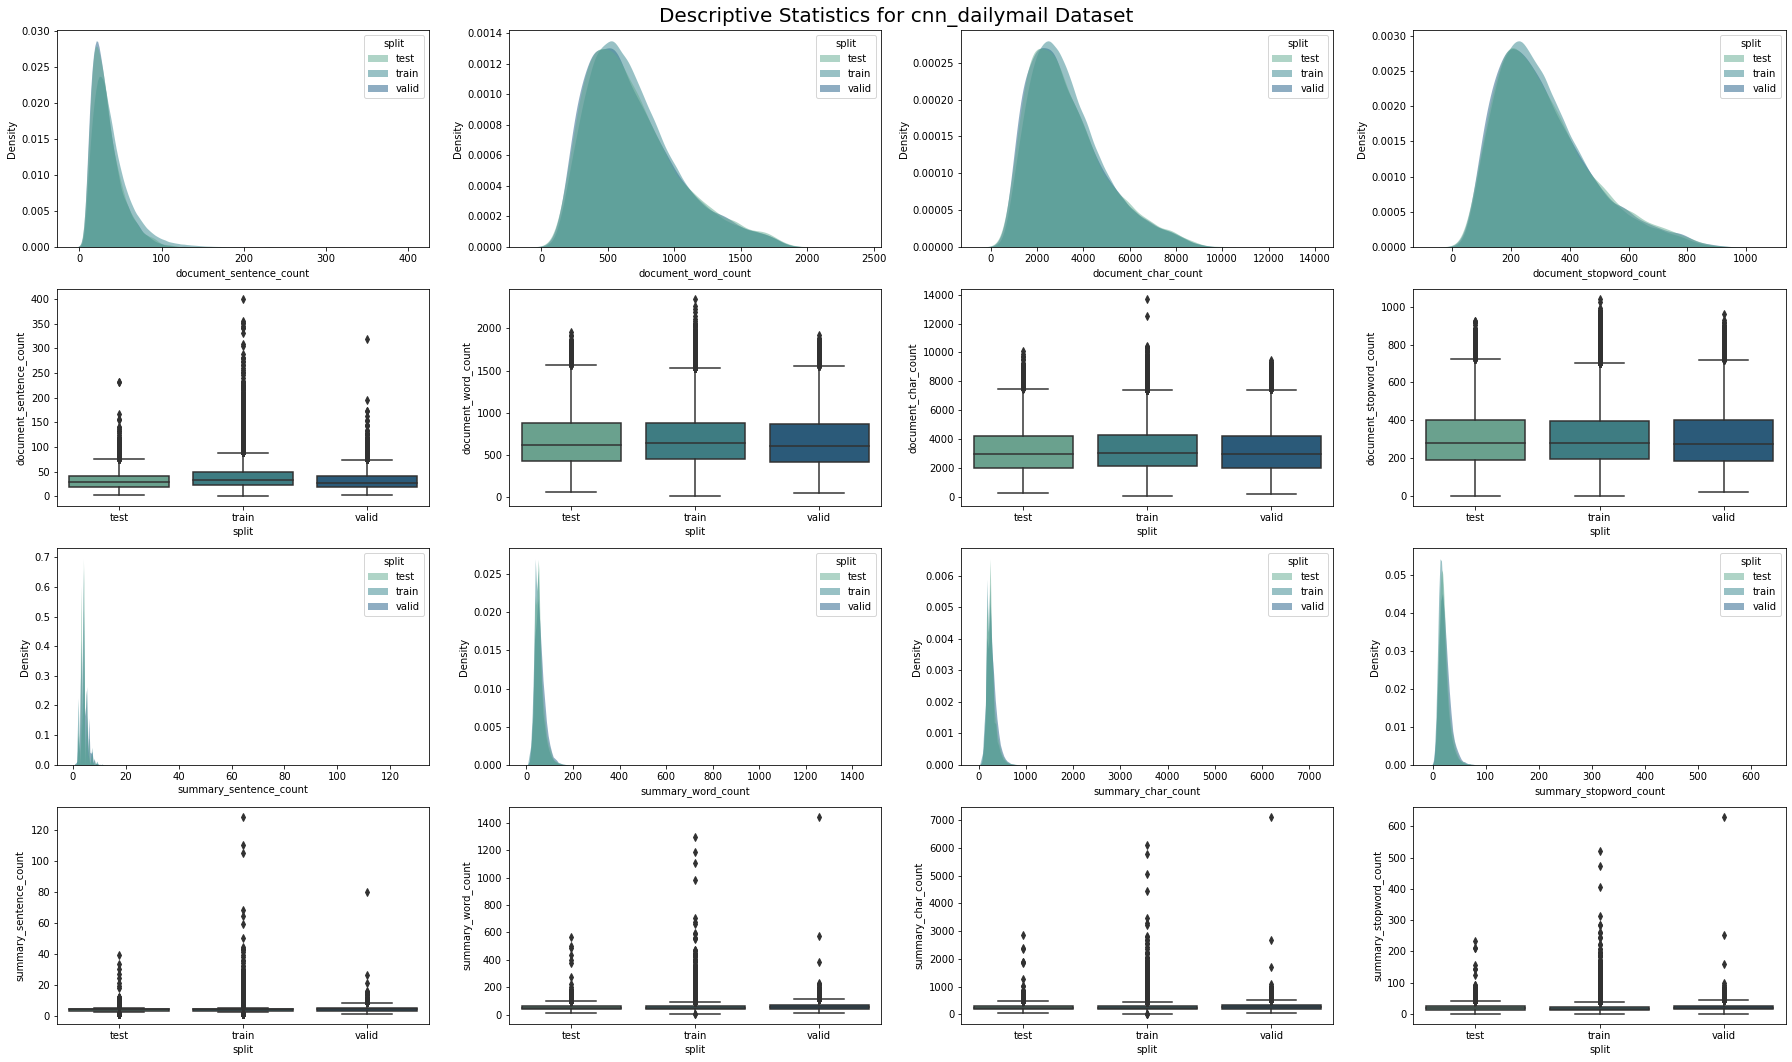

count    mean     std  \
cnn_dailymail test  document char_count        11490.00 3283.61 1677.66   
                             sentence_count    11490.00   33.37   18.97   
                             sentence_density  11490.00    0.05    0.01   
                             stopword_count    11490.00  311.67  163.06   
                             word_count        11490.00  683.53  348.41   
                    summary  char_count        11490.00  257.83  105.83   
                             sentence_count    11490.00    3.92    1.34   
                             sentence_density  11490.00    0.07    0.01   
                             stopword_count    11490.00   20.89   10.55   
                             word_count        11490.00   55.01   22.52   
              train document char_count       287113.00 3341.85 1619.20   
                             sentence_count   287113.00   39.10   23.58   
                             sentence_density 287113.00    0.06    0.01   
                             stopword_count   287113.00  308.80  156.15   
                             word_count       287113.00  691.89  336.51   
                    summary  char_count       287113.00  244.16   99.27   
                             sentence_count   287113.00    3.83    1.40   
                             sentence_density 287113.00    0.08    0.02   
                             stopword_count   287113.00   19.02    9.96   
                             word_count       287113.00   51.57   21.26   
              valid document char_count        13368.00 3247.72 1650.23   
                             sentence_count    13368.00   32.79   18.68   
                             sentence_density  13368.00    0.05    0.01   
                             stopword_count    13368.00  308.92  162.29   
                             word_count        13368.00  676.04  343.56   
                    summary  char_count        13368.00  271.01  120.98   
                             sentence_count    13368.00    4.15    1.52   
                             sentence_density  13368.00    0.07    0.01   
                             stopword_count    13368.00   22.14   11.90   
                             word_count        13368.00   57.91   25.61   

                                                 min     25%     50%     75%  \
cnn_dailymail test  document char_count       239.00 2010.00 2949.50 4199.00   
                             sentence_count     2.00   20.00   29.00   42.00   
                             sentence_density   0.02    0.04    0.05    0.05   
                             stopword_count     0.00  189.00  279.00  402.00   
                             word_count        55.00  419.00  613.00  876.00   
                    summary  char_count        42.00  185.00  240.00  297.00   
                             sentence_count     1.00    3.00    4.00    4.00   
                             sentence_density   0.03    0.07    0.08    0.08   
                             stopword_count     0.00   14.00   19.00   25.00   
                             word_count         9.00   40.00   51.00   64.00   
              train document char_count        41.00 2140.00 3049.00 4238.00   
                             sentence_count     1.00   23.00   33.00   49.00   
                             sentence_density   0.01    0.05    0.05    0.06   
                             stopword_count     0.00  193.00  280.00  396.00   
                             word_count         8.00  443.00  632.00  877.00   
                    summary  char_count        11.00  181.00  232.00  284.00   
                             sentence_count     1.00    3.00    4.00    4.00   
                             sentence_density   0.02    0.07    0.08    0.09   
                             stopword_count     0.00   13.00   17.00   23.00   
                             word_count         4.00   38.00   48.00   60.00   
              valid document char_count     

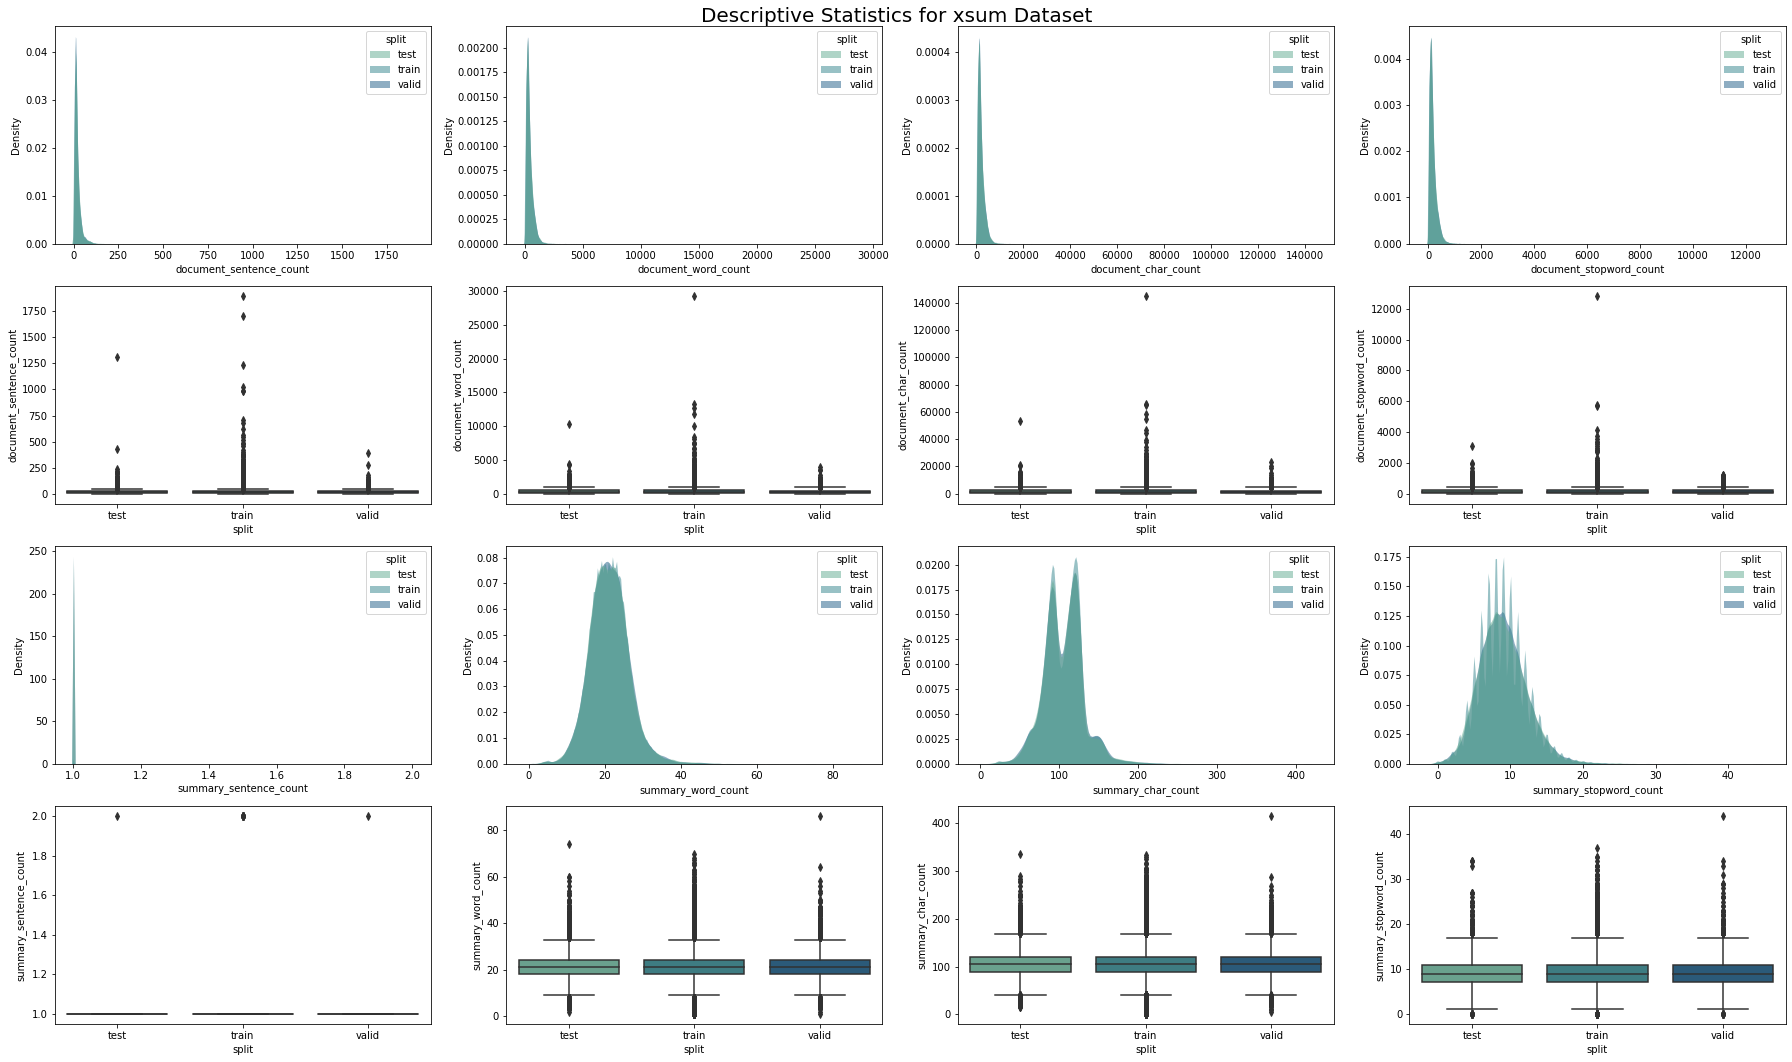

count    mean     std   min    25%  \
xsum test  document char_count        11334.00 1838.74 1509.82  0.00 876.00   
                    sentence_count    11334.00   20.00   21.84  0.00   9.00   
                    sentence_density  11334.00    0.05    0.02  0.00   0.05   
                    stopword_count    11334.00  171.81  142.25  0.00  79.00   
                    word_count        11334.00  376.15  308.25  0.00 179.00   
           summary  char_count        11334.00  105.29   25.66 15.00  89.00   
                    sentence_count    11334.00    1.00    0.01  1.00   1.00   
                    sentence_density  11334.00    0.05    0.02  0.01   0.04   
                    stopword_count    11334.00    8.95    3.34  0.00   7.00   
                    word_count        11334.00   21.10    5.32  2.00  18.00   
     train document char_count       204045.00 1828.80 1491.24  0.00 864.00   
                    sentence_count   204045.00   19.78   19.35  0.00   9.00   
                    sentence_density 204045.00    0.05    0.01  0.00   0.05   
                    stopword_count   204045.00  170.25  142.02  0.00  78.00   
                    word_count       204045.00  373.87  304.67  0.00 176.00   
           summary  char_count       204045.00  105.36   25.47  1.00  89.00   
                    sentence_count   204045.00    1.00    0.01  1.00   1.00   
                    sentence_density 204045.00    0.05    0.02  0.01   0.04   
                    stopword_count   204045.00    8.93    3.26  0.00   7.00   
                    word_count       204045.00   21.10    5.24  1.00  18.00   
     valid document char_count        11332.00 1805.28 1384.04  0.00 867.00   
                    sentence_count    11332.00   19.33   16.88  0.00   9.00   
                    sentence_density  11332.00    0.05    0.01  0.00   0.05   
                    stopword_count    11332.00  168.53  133.15  0.00  77.00   
                    word_count        11332.00  369.14  282.02  0.00 177.00   
           summary  char_count        11332.00  105.46   25.66  5.00  89.00   
                    sentence_count    11332.00    1.00    0.01  1.00   1.00   
                    sentence_density  11332.00    0.05    0.02  0.01   0.04   
                    stopword_count    11332.00    8.98    3.30  0.00   7.00   
                    word_count        11332.00   21.13    5.27  1.00  18.00   

                                         50%     75%       max  
xsum test  document char_count       1444.00 2411.75  53619.00  
                    sentence_count     15.00   24.00   1310.00  
                    sentence_density    0.05    0.06      0.50  
                    stopword_count    133.00  224.00   3115.00  
                    word_count        295.00  492.00  10316.00  
           summary  char_count        106.00  121.00    337.00  
                    sentence_count      1.00    1.00      2.00  
                    sentence_density    0.05    0.06      0.50  
                    stopword_count      9.00   11.00     34.00  
                    word_count         21.00   24.00     74.00  
     train document char_count       1447.00 2408.00 144825.00  
                    sentence_count     15.00   24.00   1895.00  
                    sentence_density    0.05    0.06      1.00  
                    stopword_count    133.00  223.00  12816.00  
                    word_count        295.00  491.00  29259.00  
           summary  char_count        106.00  121.00    333.00  
                    sentence_count      1.00    1.00      2.00  
                    sentence_density    0.05    0.06      1.00  
                    stopword_count      9.00   11.00     37.00  
                    word_count         21.00   24.00     70.00  
     valid document char_count       1432.00 2362.00  23408.00  
                    sentence_count     15.00   24.00    389.00  
                    sentence_density    0.05    0.06      0.28  
                    stopword_co

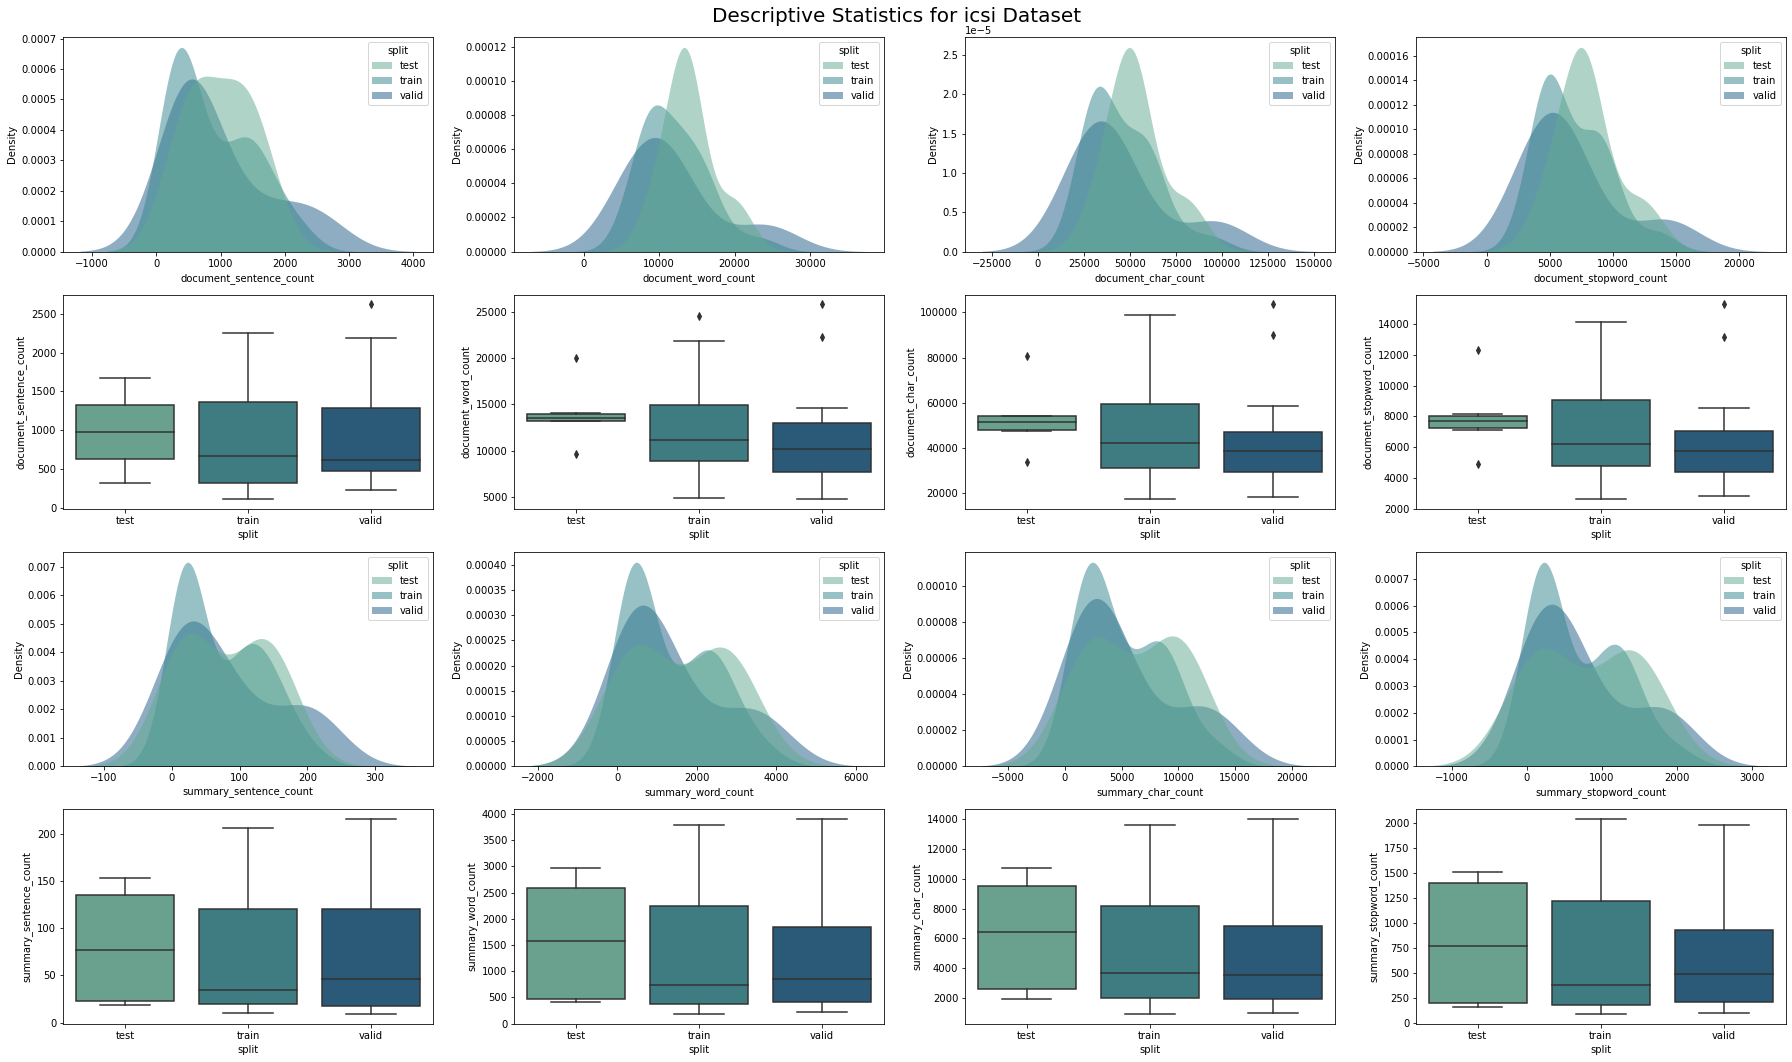

count     mean      std      min  \
icsi test  document char_count         6.00 53147.50 15395.26 33797.00   
                    sentence_count     6.00   984.83   513.62   325.00   
                    sentence_density   6.00     0.07     0.03     0.03   
                    stopword_count     6.00  7973.17  2406.22  4916.00   
                    word_count         6.00 13983.50  3370.01  9598.00   
           summary  char_count         6.00  6242.83  4058.40  1954.00   
                    sentence_count     6.00    81.00    64.03    19.00   
                    sentence_density   6.00     0.05     0.00     0.05   
                    stopword_count     6.00   804.67   671.72   161.00   
                    word_count         6.00  1591.17  1225.66   409.00   
     train document char_count        41.00 45582.49 18562.34 17258.00   
                    sentence_count    41.00   872.51   622.50   114.00   
                    sentence_density  41.00     0.07     0.03     0.02   
                    stopword_count    41.00  6841.12  2728.53  2627.00   
                    word_count        41.00 11993.10  4372.22  4859.00   
           summary  char_count        41.00  5130.56  3561.61   916.00   
                    sentence_count    41.00    73.07    59.10    10.00   
                    sentence_density  41.00     0.05     0.01     0.04   
                    stopword_count    41.00   687.00   563.35    88.00   
                    word_count        41.00  1335.20  1064.06   184.00   
     valid document char_count        12.00 45109.58 26685.19 18352.00   
                    sentence_count    12.00   970.83   777.92   231.00   
                    sentence_density  12.00     0.08     0.03     0.04   
                    stopword_count    12.00  6732.42  3870.65  2821.00   
                    word_count        12.00 11838.58  6402.64  4716.00   
           summary  char_count        12.00  5280.08  4538.13   988.00   
                    sentence_count    12.00    80.17    78.76     9.00   
                    sentence_density  12.00     0.05     0.01     0.04   
                    stopword_count    12.00   715.50   687.07    95.00   
                    word_count        12.00  1384.08  1304.38   218.00   

                                          25%      50%      75%       max  
icsi test  document char_count       47934.50 51378.50 53909.75  80791.00  
                    sentence_count     627.75   979.50  1323.75   1676.00  
                    sentence_density     0.04     0.07     0.09      0.10  
                    stopword_count    7243.00  7697.00  8031.00  12295.00  
                    word_count       13217.75 13510.00 13988.25  20015.00  
           summary  char_count        2610.50  6449.50  9525.00  10723.00  
                    sentence_count      23.25    76.50   135.00    154.00  
                    sentence_density     0.05     0.05     0.05      0.06  
                    stopword_count     200.75   770.00  1397.00   1510.00  
                    word_count         471.50  1568.50  2583.75   2973.00  
     train document char_count       31103.00 42209.00 59370.00  99034.00  
                    sentence_count     326.00   669.00  1362.00   2258.00  
                    sentence_density     0.03     0.06     0.10      0.11  
                    stopword_count    4804.00  6187.00  9033.00  14126.00  
                    word_count        8879.00 11158.00 14968.00  24596.00  
           summary  char_count        1977.00  3662.00  8181.00  13612.00  
                    sentence_count      20.00    35.00   121.00    207.00  
                    sentence_density     0.05     0.05     0.06      0.12  
                    stopword_count     183.00   374.00  1215.00   2037.00  
                    word_count         378.00   747.00  2239.00   3779.00  
     valid document char_count       29526.75 38586.50 46936.00 103541.00  
                    sentence_count     475.50   619.50  1286.25   2621.

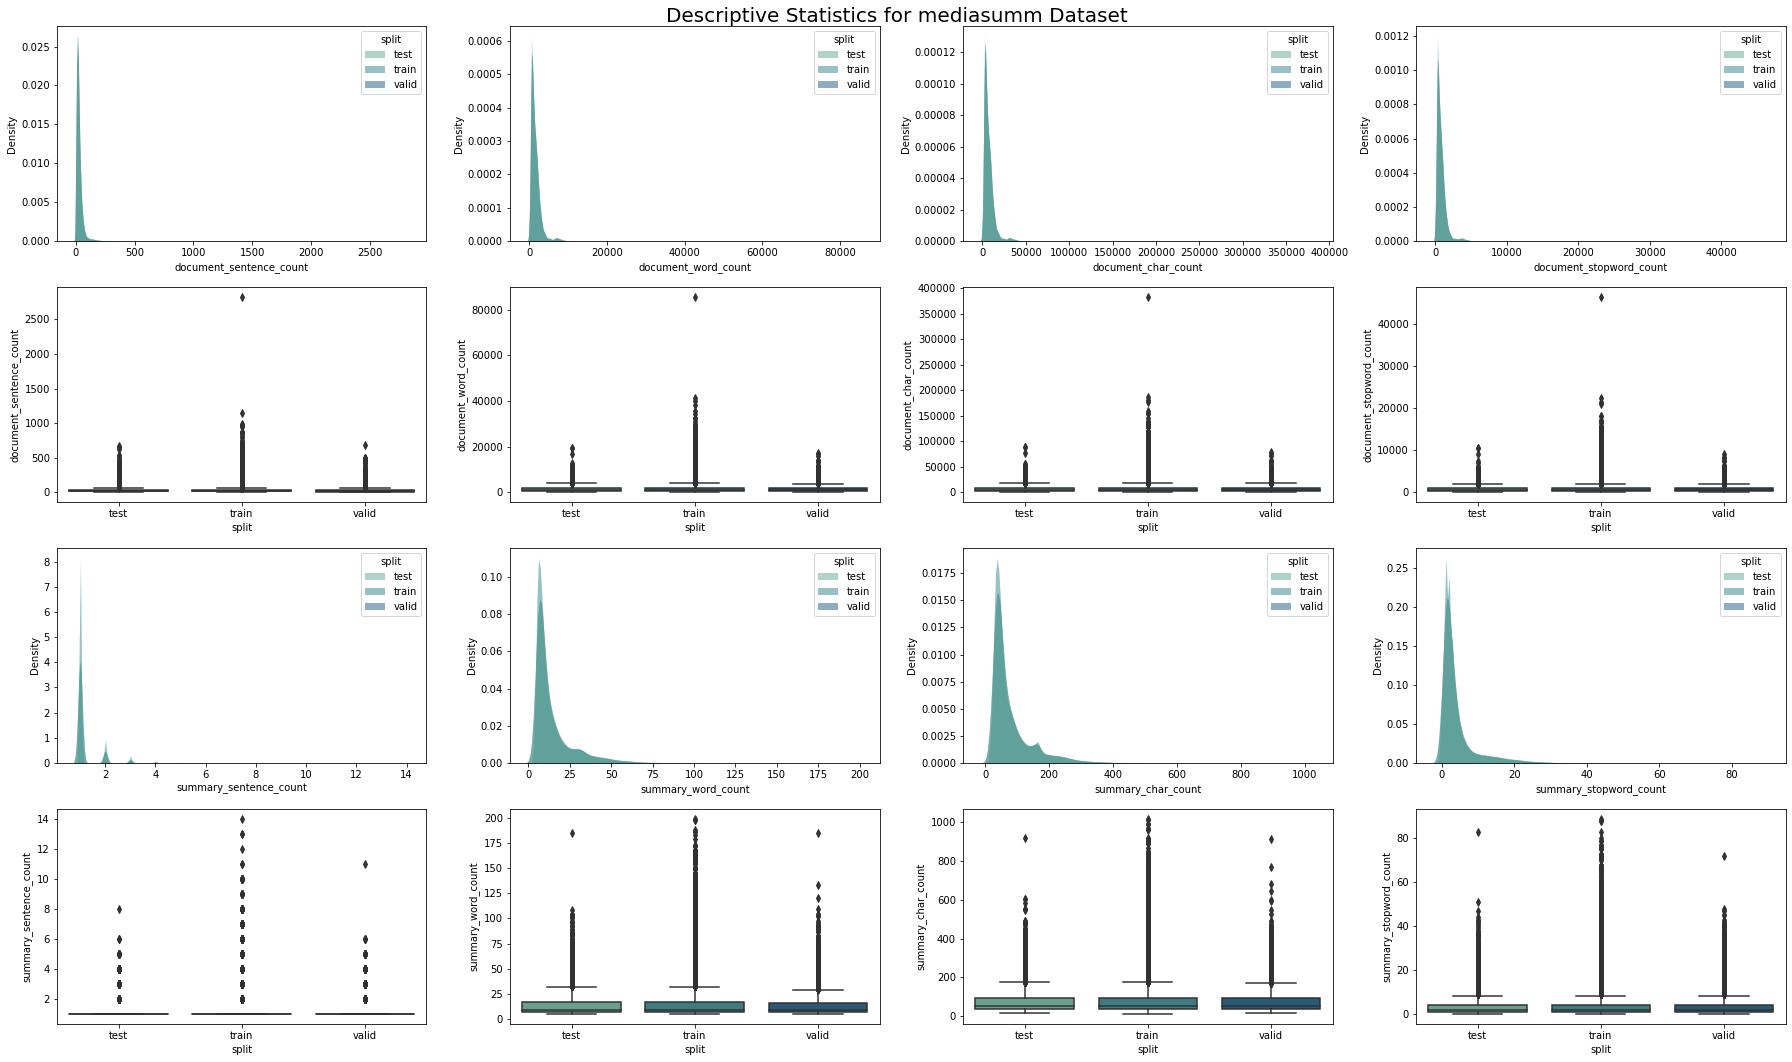

count    mean     std    min  \
mediasumm test  document char_count        10000.00 7183.20 6305.88  72.00   
                         sentence_count    10000.00   30.56   36.64   1.00   
                         sentence_density  10000.00    0.02    0.01   0.00   
                         stopword_count    10000.00  802.46  737.49   8.00   
                         word_count        10000.00 1562.47 1394.88  14.00   
                summary  char_count        10000.00   78.55   66.07  15.00   
                         sentence_count    10000.00    1.19    0.53   1.00   
                         sentence_density  10000.00    0.11    0.05   0.01   
                         stopword_count    10000.00    4.07    5.24   0.00   
                         word_count        10000.00   14.36   12.53   5.00   
          train document char_count       443596.00 7150.80 6497.40  25.00   
                         sentence_count   443596.00   30.03   36.24   1.00   
                         sentence_density 443596.00    0.02    0.01   0.00   
                         stopword_count   443596.00  797.93  755.66   0.00   
                         word_count       443596.00 1554.04 1433.43   5.00   
                summary  char_count       443596.00   78.91   67.11  11.00   
                         sentence_count   443596.00    1.19    0.54   1.00   
                         sentence_density 443596.00    0.11    0.06   0.01   
                         stopword_count   443596.00    4.09    5.32   0.00   
                         word_count       443596.00   14.40   12.71   5.00   
          valid document char_count        10000.00 7041.13 6208.92 161.00   
                         sentence_count    10000.00   29.28   33.79   1.00   
                         sentence_density  10000.00    0.02    0.01   0.00   
                         stopword_count    10000.00  785.72  722.74  13.00   
                         word_count        10000.00 1529.72 1369.52  31.00   
                summary  char_count        10000.00   77.84   66.25  15.00   
                         sentence_count    10000.00    1.19    0.54   1.00   
                         sentence_density  10000.00    0.12    0.06   0.01   
                         stopword_count    10000.00    4.00    5.25   0.00   
                         word_count        10000.00   14.20   12.54   5.00   

                                              25%     50%     75%       max  
mediasumm test  document char_count       3200.00 5438.50 9178.25  89085.00  
                         sentence_count     13.00   21.50   36.00    675.00  
                         sentence_density    0.01    0.02    0.02      0.11  
                         stopword_count    346.00  608.00 1016.00  10532.00  
                         word_count        688.00 1186.50 1991.00  19556.00  
                summary  char_count         38.00   53.00   93.00    920.00  
                         sentence_count      1.00    1.00    1.00      8.00  
                         sentence_density    0.07    0.11    0.17      0.40  
                         stopword_count      1.00    2.00    4.00     83.00  
                         word_count          7.00    9.00   17.00    185.00  
          train document char_count       3185.00 5434.00 9032.00 382791.00  
                         sentence_count     13.00   21.00   35.00   2827.00  
                         sentence_density    0.01    0.02    0.02      0.25  
                         stopword_count    343.00  607.00  995.00  46458.00  
                         word_count        684.00 1184.00 1954.00  85557.00  
                summary  char_count         38.00   52.00   93.00   1019.00  
                         sentence_count      1.00    1.00    1.00     14.00  
                         sentence_density    0.07    0.11    0.17      0.60  
                         stopword_count      1.00    2.00    4.00     89.00  
                         word_count          7.00    9.00   17.00  

In [210]:
info_splits = load_data_splits_from_dir(RAW_SUMMARIZATION_DATASETS_DIR, ext="csv")
descriptions = []
for name, splits in info_splits.items():
    dataset_subset = []
    dataset_subset_description = []
    for split, fname in splits.items():
        data_info = pd.read_csv(fname)
        split = split.split('_')[0]
        description = data_info.describe().T
        description = description.set_index(pd.MultiIndex.from_tuples([(name, split, col.split("_")[0], "_".join(col.split("_")[1:]))for col in description.index]))
        descriptions.append(description)
        
        data_info["dataset"] = name
        data_info["split"] = split

        
        dataset_subset.append(data_info)
        dataset_subset_description.append(description)
        
    
    ## display the described dataframe for each dataset
    dataset_subset_description = pd.concat(dataset_subset_description)
    dataset_subset = pd.concat(dataset_subset).reset_index(drop=True)
    show_data_dists(dataset_subset, name)
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        display(dataset_subset_description)
descriptions= pd.concat(descriptions, axis=0)

In [212]:


nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textrank")


def summarize_examples(examples):
    docs = nlp.pipe([" ".join(document) for document in examples["document"]])
    output_summaries = []
    for doc, summary in zip(docs, examples["summary"]):
        output_summary = doc._.textrank.summary(limit_sentences=len(summary))
        output_summaries.append([item.text for item in  output_summary])
    return {"predicted_summary": output_summaries}

In [255]:

metric = datasets.load_metric("rouge")

def stringify_summaries(examples):
    return {"summary":["\n".join(document) for document in examples["summary"]],
    "predicted_summary":["\n".join(document) for document in examples["predicted_summary"]],
    }
def compute_rouge(examples):
    result = metric.compute(predictions=examples["predicted_summary"], references=examples["summary"], use_stemmer=True)
    return result


data_splits = load_data_splits_from_dir(RAW_SUMMARIZATION_DATASETS_DIR)
features = datasets.features.Features({
    'document': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None),
    'summary': datasets.Sequence(feature=datasets.Value(dtype='string', id=None), length=-1, id=None)
    })

baseline_scores = {}
for name, splits in tqdm(data_splits.items()):
    test_dataset = datasets.load_dataset("json", name, data_files={"test": splits["test"]}, features=features,)["test"]
    test_dataset = test_dataset.map(summarize_examples, batched=True)
    test_dataset = test_dataset.map(stringify_summaries, batched=True, remove_columns=test_dataset.column_names)
    test_dataset = test_dataset.to_pandas()
    baseline_scores[name] = compute_rouge(test_dataset)


  0%|          | 0/8 [00:00<?, ?it/s]

Using custom data configuration ami-99ed44eeb3777dbb
Reusing dataset json (/Users/bebop/.cache/huggingface/datasets/json/ami-99ed44eeb3777dbb/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50)
100%|██████████| 1/1 [00:00<00:00, 16.37ba/s]
Using custom data configuration ted-d02517bddf01289d


100%|██████████| 1/1 [00:00<00:00, 339.54it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/ted-d02517bddf01289d/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00,  6.92ba/s]
Using custom data configuration cc_news-1d7d164a6eb6199a


100%|██████████| 1/1 [00:00<00:00, 382.55it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/cc_news-1d7d164a6eb6199a/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 71/71 [00:02<00:00, 25.77ba/s]
Using custom data configuration spotify-6f42c45baf46a8ad


100%|██████████| 1/1 [00:00<00:00, 273.60it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/spotify-6f42c45baf46a8ad/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 10/10 [00:03<00:00,  3.11ba/s]
Using custom data configuration cnn_dailymail-9a191c8cf1cd27b3


100%|██████████| 1/1 [00:00<00:00, 141.30it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/cnn_dailymail-9a191c8cf1cd27b3/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 12/12 [00:00<00:00, 18.30ba/s]
Using custom data configuration xsum-afbed37fba421d98


100%|██████████| 1/1 [00:00<00:00, 673.89it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/xsum-afbed37fba421d98/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 12/12 [00:00<00:00, 23.52ba/s]
Using custom data configuration icsi-64fc637f3e185af8


100%|██████████| 1/1 [00:00<00:00, 996.98it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/icsi-64fc637f3e185af8/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 1/1 [00:00<00:00, 12.05ba/s]
Using custom data configuration mediasumm-7c13f9e2954b4ed0


100%|██████████| 1/1 [00:00<00:00, 570.89it/s]


Dataset json downloaded and prepared to /Users/bebop/.cache/huggingface/datasets/json/mediasumm-7c13f9e2954b4ed0/0.0.0/d75ead8d5cfcbe67495df0f89bd262f0023257fbbbd94a730313295f3d756d50. Subsequent calls will reuse this data.


100%|██████████| 10/10 [00:01<00:00,  8.56ba/s]


In [295]:
scores = {}
for dataset, baseline in baseline_scores.items():

    # print(dict(baseline))
    for k,v in baseline.items():
        scores[(dataset,k,"low",)] = {"fmeasure": v.low.fmeasure, "recall": v.low.recall,"precision": v.low.precision}

        scores[(dataset,k,"mid",)] = {"fmeasure": v.mid.recall, "recall": v.mid.recall, "precision": v.mid.precision}
        scores[(dataset,k,"high",)]  = {"fmeasure": v.high.recall, "precision": v.high.precision, "recall": v.high.recall}

baseline_scores = pd.DataFrame(scores).T
display(HTML(baseline_scores.to_html()))

baseline_scores.to_json("/Users/bebop/Documents/courses/APCOMP215/AC215_projectgarble/datasets/raw/supervised/summarization/baseline_scores.json")